# Ivan Lee, Keane Ng, Liew Khye Lerk

In [ ]:
 from google.colab import auth 
auth.authenticate_user()

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

from keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D, MaxPooling1D, Conv1D, concatenate, Flatten, LSTM, Reshape
from tensorflow.keras.models import Model, Sequential
from keras.layers.embeddings import Embedding
from keras.regularizers import l2

#Import data

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Safety_DataSet_Aggregated.csv')
labels = pd.read_csv('/content/drive/My Drive/Colab Notebooks/labels.csv')

# Exploratory Data Analysis

In [ ]:
labels.head(5)

,bookingID,label
0,111669149733,0
1,335007449205,1
2,171798691856,0
3,1520418422900,0
4,798863917116,0


In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20018 entries, 0 to 20017
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   bookingID  20018 non-null  int64
 1   label      20018 non-null  int64
dtypes: int64(2)
memory usage: 312.9 KB


In [ ]:
labels.isnull().any()

bookingID    False
label        False
dtype: bool

In [ ]:
len(labels['bookingID'])

20018

In [ ]:
len(labels['bookingID'].unique())

20000

In [ ]:
labels.duplicated(subset="bookingID").any()

True

In [ ]:
labels.drop_duplicates(subset="bookingID", keep="last", inplace=True)

In [ ]:
labels.duplicated(subset="bookingID").any()

False

In [ ]:
data.head(5)

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,label
0,0,12.0,143.298294,0.818112,-9.941461,-2.014999,-0.016245,-0.094040,0.070732,0.0,3.442991,0
1,0,8.0,143.298294,0.546405,-9.835590,-2.038925,-0.047092,-0.078874,0.043187,1.0,0.228454,0
2,0,8.0,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454,0
3,0,8.0,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.228454,0
4,0,8.0,143.298294,-0.598145,-9.853534,-1.378574,-0.014297,-0.046206,0.021902,4.0,0.228454,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16154418 entries, 0 to 16154417
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   bookingID       int64  
 1   Accuracy        float64
 2   Bearing         float64
 3   acceleration_x  float64
 4   acceleration_y  float64
 5   acceleration_z  float64
 6   gyro_x          float64
 7   gyro_y          float64
 8   gyro_z          float64
 9   second          float64
 10  Speed           float64
 11  label           int64  
dtypes: float64(10), int64(2)
memory usage: 1.4 GB


In [ ]:
data.isnull().any()

bookingID         False
Accuracy          False
Bearing           False
acceleration_x    False
acceleration_y    False
acceleration_z    False
gyro_x            False
gyro_y            False
gyro_z            False
second            False
Speed             False
label             False
dtype: bool

In [ ]:
data.duplicated().any()

False

# Feature Engineering

In [ ]:
df = pd.DataFrame()
for col in data.columns:
    if col != "bookingID" and col != "label" and col != "gyro_x" and col != "gyro_y" and col != "gyro_z":
        temp = data.groupby("bookingID")[col].agg(["mean", "sum", "max", "min"])
        df[col + "_mean"] = temp["mean"]
        df[col + "_sum"] = temp["sum"]
        df[col + "_max"] = temp["max"]
        df[col + "_min"] = temp["min"]

In [ ]:
for col in df.columns:
    if col.startswith("second"):
        agg_method = col.split("_")[1]
        df["distance_" + agg_method] = df[col] * df["Speed_" + agg_method]
        df["velocity_x_" + agg_method] = df[col] * df["acceleration_x_" + agg_method]
        df["velocity_y_" + agg_method] = df[col] * df["acceleration_y_" + agg_method]
        df["velocity_z_" + agg_method] = df[col] * df["acceleration_z_" + agg_method]

In [ ]:
len(df)

20000

In [ ]:
df = pd.merge(df, labels, on="bookingID")

In [ ]:
df.head(5)

,bookingID,Accuracy_mean,Accuracy_sum,Accuracy_max,Accuracy_min,Bearing_mean,Bearing_sum,Bearing_max,Bearing_min,acceleration_x_mean,acceleration_x_sum,acceleration_x_max,acceleration_x_min,acceleration_y_mean,acceleration_y_sum,acceleration_y_max,acceleration_y_min,acceleration_z_mean,acceleration_z_sum,acceleration_z_max,acceleration_z_min,second_mean,second_sum,second_max,second_min,Speed_mean,Speed_sum,Speed_max,Speed_min,distance_mean,velocity_x_mean,velocity_y_mean,velocity_z_mean,distance_sum,velocity_x_sum,velocity_y_sum,velocity_z_sum,distance_max,velocity_x_max,velocity_y_max,velocity_z_max,distance_min,velocity_x_min,velocity_y_min,velocity_z_min,label
0,0,10.165339,10206.000,48.000,4.0,176.526099,177232.203582,359.979767,0.037464,-0.711264,-714.108606,4.782614,-4.692294,-9.613822,-9652.277441,-6.119916,-12.764703,-1.619658,-1626.136658,2.318857,-6.251807,903.526892,907141.0,1589.0,0.0,8.994822,9030.801222,22.946083,-1.0,8127.063510,-642.645747,-8686.346854,-1463.404583,8.192210e+09,-6.477972e+08,-8.755977e+09,-1.475135e+09,36461.325996,7599.573862,-9724.546161,3684.663474,-0.0,-0.0,-0.0,-0.0,0
1,1,3.718763,3164.667,7.709,3.0,124.198590,105693.000000,337.000000,0.000000,-0.525406,-447.120797,3.813341,-5.352994,9.532086,8111.805312,12.536156,6.623425,-2.198999,-1871.348183,1.481293,-5.355455,581.175088,494580.0,1034.0,0.0,7.881588,6707.231233,21.882141,-1.0,4580.582495,-305.353077,5539.811007,-1278.003461,3.317262e+09,-2.211370e+08,4.011937e+09,-9.255314e+08,22626.133794,3942.994594,12962.385304,1531.656548,-0.0,-0.0,0.0,-0.0,1
2,2,3.930626,766.472,8.000,3.0,173.794872,33890.000000,354.000000,1.000000,0.306786,59.823351,1.956122,-2.971295,9.843183,1919.420684,13.333716,7.941810,0.139347,27.172626,2.312870,-3.282551,339.441026,66191.0,825.0,0.0,3.157213,615.656528,9.360483,0.0,1071.687607,104.135895,3341.180132,47.300020,4.075092e+07,3.959767e+06,1.270484e+08,1.798583e+06,7722.398475,1613.801062,11000.315700,1908.117338,0.0,-0.0,0.0,-0.0,1
3,4,10.000000,10940.000,10.000,10.0,151.807013,166076.872711,353.855377,2.271227,-0.365117,-399.438525,2.019635,-2.866458,-9.406439,-10290.643753,-7.064984,-18.847833,-2.613639,-2859.321069,0.296381,-9.374869,547.495430,598960.0,1094.0,0.0,6.150996,6729.190006,19.780001,0.0,3367.642389,-199.900153,-5149.982105,-1430.955409,4.030516e+09,-2.392477e+08,-6.163684e+09,-1.712619e+09,21639.320751,2209.480701,-7729.092639,324.240393,0.0,-0.0,-0.0,-0.0,1
4,6,4.586721,5022.460,12.000,3.0,197.812785,216605.000000,359.000000,0.000000,0.490616,537.224988,5.593026,-4.352792,9.538043,10444.157133,13.249917,6.469330,2.355059,2578.789598,7.977724,-2.140482,547.000000,598965.0,1094.0,0.0,4.628921,5068.669039,16.394695,0.0,2532.020059,268.367186,5217.309545,1288.217270,3.035955e+09,3.217790e+08,6.255685e+09,1.544605e+09,17935.796330,6118.770444,14495.409198,8727.629618,0.0,-0.0,0.0,-0.0,0


In [ ]:
df.isnull().any()

bookingID              False
Accuracy_mean          False
Accuracy_sum           False
Accuracy_max           False
Accuracy_min           False
Bearing_mean           False
Bearing_sum            False
Bearing_max            False
Bearing_min            False
acceleration_x_mean    False
acceleration_x_sum     False
acceleration_x_max     False
acceleration_x_min     False
acceleration_y_mean    False
acceleration_y_sum     False
acceleration_y_max     False
acceleration_y_min     False
acceleration_z_mean    False
acceleration_z_sum     False
acceleration_z_max     False
acceleration_z_min     False
second_mean            False
second_sum             False
second_max             False
second_min             False
Speed_mean             False
Speed_sum              False
Speed_max              False
Speed_min              False
distance_mean          False
velocity_x_mean        False
velocity_y_mean        False
velocity_z_mean        False
distance_sum           False
velocity_x_sum

In [ ]:
df.duplicated().any()

False

In [ ]:
df = df.drop(columns=["bookingID"]).reset_index(drop=True)

#Feature Selection

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 45 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Accuracy_mean        20000 non-null  float64
 1   Accuracy_sum         20000 non-null  float64
 2   Accuracy_max         20000 non-null  float64
 3   Accuracy_min         20000 non-null  float64
 4   Bearing_mean         20000 non-null  float64
 5   Bearing_sum          20000 non-null  float64
 6   Bearing_max          20000 non-null  float64
 7   Bearing_min          20000 non-null  float64
 8   acceleration_x_mean  20000 non-null  float64
 9   acceleration_x_sum   20000 non-null  float64
 10  acceleration_x_max   20000 non-null  float64
 11  acceleration_x_min   20000 non-null  float64
 12  acceleration_y_mean  20000 non-null  float64
 13  acceleration_y_sum   20000 non-null  float64
 14  acceleration_y_max   20000 non-null  float64
 15  acceleration_y_min   20000 non-null 

In [ ]:
corr=abs(df.corr()['label']).sort_values(ascending = False)
print(corr)

label                  1.000000
Bearing_sum            0.196237
acceleration_x_max     0.168572
acceleration_x_min     0.158021
acceleration_z_max     0.156995
acceleration_z_min     0.128672
Speed_sum              0.121857
Bearing_max            0.108010
Bearing_min            0.095364
Speed_min              0.089194
acceleration_y_min     0.075424
Speed_mean             0.072482
acceleration_y_max     0.058552
acceleration_y_sum     0.051582
acceleration_z_sum     0.047572
Accuracy_sum           0.040019
Accuracy_max           0.033616
acceleration_z_mean    0.033264
Speed_max              0.030936
Bearing_mean           0.022991
distance_max           0.008551
second_max             0.008332
velocity_y_max         0.008233
acceleration_x_sum     0.008099
Accuracy_min           0.008008
velocity_x_max         0.007941
velocity_z_max         0.007580
acceleration_y_mean    0.006820
Accuracy_mean          0.006366
distance_mean          0.005958
second_sum             0.005617
velocity

In [ ]:
df.drop(columns=["second_min", "distance_min", "velocity_x_min", "velocity_y_min", "velocity_z_min"], inplace=True)

# Model Training

In [ ]:
features = ["Bearing_sum", "acceleration_x_max", "acceleration_z_max", "Speed_sum", "Bearing_max", "acceleration_x_min", "acceleration_z_min", "Bearing_min", "Speed_min", "acceleration_y_min"]

In [ ]:
X_test = df.drop(columns=["label"]).reset_index(drop=True)
X_test = X_test[features]
X_test = X_test.astype('float32')
y_test = df.label.reset_index(drop=True)

train_X, test_X, train_y, test_y = train_test_split(X_test, y_test, test_size=0.2)
train2_X, val2_X, train2_y, val2_y = train_test_split(train_X, train_y, test_size=0.333)

In [ ]:
# Training using Neural Network
model = Sequential()

# Flatten the results to feed into a DNN
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))
# Only 1 output neuron. 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

history = model.fit(train2_X, train2_y, epochs=500, batch_size=25, verbose=2, callbacks=[es], validation_data = (val2_X, val2_y))

Epoch 1/500
427/427 - 1s - loss: 1547.4532 - acc: 0.5962 - val_loss: 29.6422 - val_acc: 0.4782
Epoch 2/500
427/427 - 1s - loss: 7.2706 - acc: 0.6428 - val_loss: 0.6676 - val_acc: 0.7481
Epoch 3/500
427/427 - 1s - loss: 1.0272 - acc: 0.6819 - val_loss: 0.6320 - val_acc: 0.7511
Epoch 4/500
427/427 - 1s - loss: 0.8479 - acc: 0.6887 - val_loss: 0.7548 - val_acc: 0.7483
Epoch 5/500
427/427 - 1s - loss: 0.9589 - acc: 0.6959 - val_loss: 0.7162 - val_acc: 0.7519
Epoch 6/500
427/427 - 1s - loss: 0.6641 - acc: 0.7184 - val_loss: 1.1572 - val_acc: 0.7417
Epoch 7/500
427/427 - 1s - loss: 0.6332 - acc: 0.7359 - val_loss: 0.7027 - val_acc: 0.7519
Epoch 8/500
427/427 - 1s - loss: 0.6578 - acc: 0.7458 - val_loss: 0.5655 - val_acc: 0.7513
Epoch 9/500
427/427 - 1s - loss: 0.5778 - acc: 0.7478 - val_loss: 0.6149 - val_acc: 0.7519
Epoch 10/500
427/427 - 1s - loss: 0.5835 - acc: 0.7513 - val_loss: 0.5908 - val_acc: 0.7534
Epoch 11/500
427/427 - 1s - loss: 0.6728 - acc: 0.7519 - val_loss: 0.5610 - val_acc: 

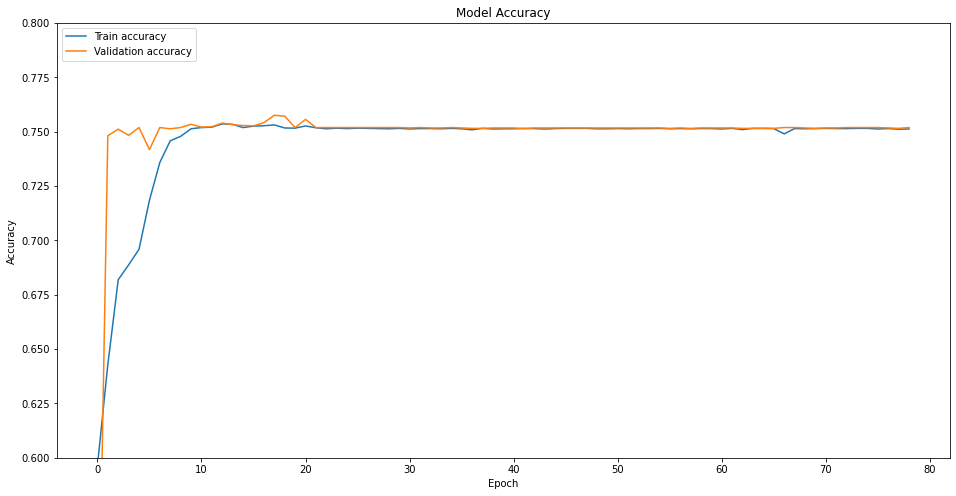

In [ ]:
# plot accuracy
names = ["Train accuracy", "Validation accuracy"]
plt.figure(figsize=(16, 8))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
axes.set_ylim([0.6, 0.8])
plt.show()

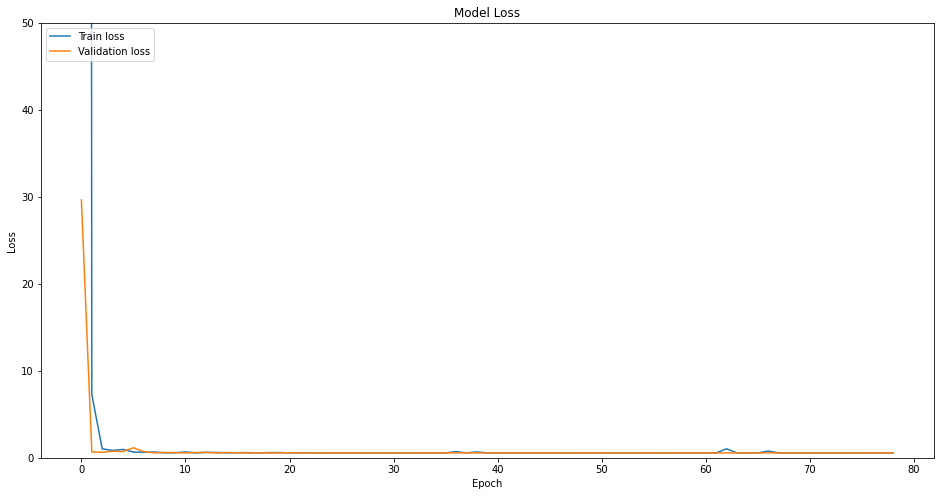

In [ ]:
# plot loss
names = ["Train loss", "Validation loss"]
plt.figure(figsize=(16, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
axes.set_ylim([0, 50])
plt.show()

In [ ]:
scores = model.evaluate(test_X, test_y)
print("Accuracy {:.2f}".format(scores[1]*100))
print("Loss {:.5f}".format(scores[0]))

125/125 [==============================] - 0s 2ms/step - loss: 0.5668 - acc: 0.7475
Accuracy 74.75
Loss 0.56677
